/playpen-raid1/tgreer/anaconda3/envs/ICON_newdir/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.1.2) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


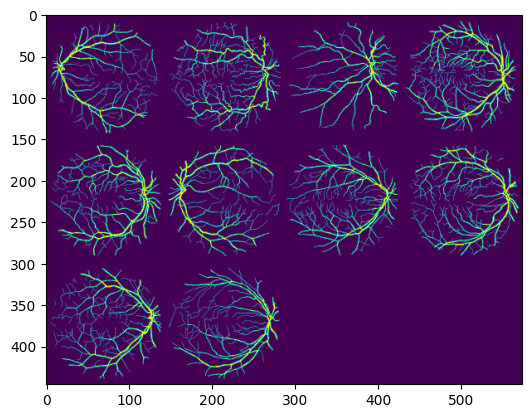

In [1]:
import icon_registration as icon
import icon_registration.data
import icon_registration.networks as networks
from icon_registration.config import device

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.utils

ds1, ds2 = icon_registration.data.get_dataset_retina(fixed_vertical_offset=None)#100

#ds1, ds2 = icon_registration.data.get_dataset_triangles(hollow=True)

sample_batch = next(iter(ds1))[0]
plt.imshow(torchvision.utils.make_grid(sample_batch[:12], nrow=4)[0])

import icon_registration as icon

In [2]:
def evaluate(net, prefix):
  net.train()
  net.to(device)

  optim = torch.optim.Adam(net.parameters(), lr=0.0005)
  curves = icon.train_datasets(net, optim, ds1, ds2, epochs=16)
  for i, name in enumerate(curves[0]._fields):

    plt.subplot(2, 3, i + 1)
    plt.plot([getattr(c, name) for c in curves])
    if name=="inverse_consistency_loss":
      name = "bending_energy_loss"
    plt.title(name)
  plt.tight_layout()
  plt.show()
  def show(tensor):
    plt.imshow(torchvision.utils.make_grid(tensor[:6], nrow=3)[0].cpu().detach())
    plt.xticks([])
    plt.yticks([])
  image_A = next(iter(ds1))[0].to(device)[:6]
  image_B = next(iter(ds2))[0].to(device)[:6]
  with torch.no_grad():
    print(net(image_A, image_B))
    try:
      net.prepare_for_viz(image_A, image_B)
    except:
      pass
  plt.subplot(2, 2, 1)
  plt.title("Moving Images")
  show(image_A)
  plt.subplot(2, 2, 2)
  plt.title("Fixed Images")
  show(image_B)
  plt.subplot(2, 2, 3)
  plt.title("Warped Images")
  show(net.warped_image_A)
  plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:6], nrow=3)[0].cpu().detach())
  plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:6], nrow=3)[1].cpu().detach())
  plt.subplot(2, 2, 4)
  plt.title("Difference Images")
  show(net.warped_image_A - image_B)
  plt.tight_layout()
  plt.show()
  plt.title("Detail of deformations")

  show(net.warped_image_A * 0)
  plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:6], nrow=3)[0].cpu().detach(), levels=np.linspace(0, 1, 35))
  plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:6], nrow=3)[1].cpu().detach(), levels=np.linspace(0, 1, 35))
  plt.show()
  plt.title("Composition of A->B and B->A transforms")
  plt.contour(net.phi_AB(net.phi_BA(net.identity_map))[0, 0].cpu().detach(), levels=35)
  plt.contour(net.phi_AB(net.phi_BA(net.identity_map))[0, 1].cpu().detach(), levels=35)
  return curves

100%|███████████████████████████████████████████| 16/16 [00:28<00:00,  1.77s/it]


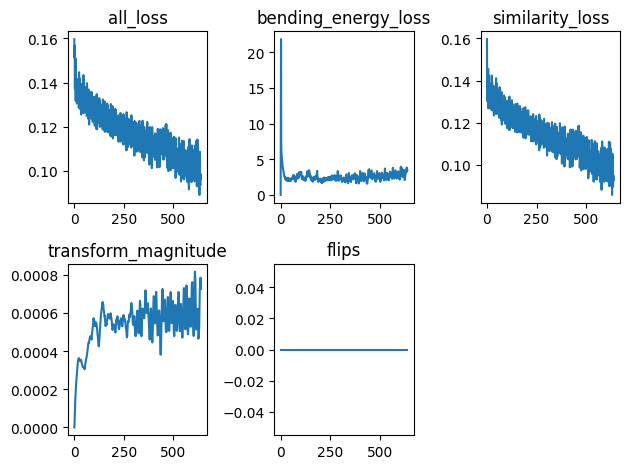

BendingLoss(all_loss=tensor(0.1030, device='cuda:0'), bending_energy_loss=tensor(2.9493, device='cuda:0'), similarity_loss=tensor(0.1001, device='cuda:0'), transform_magnitude=tensor(0.0007, device='cuda:0'), flips=tensor(0., device='cuda:0'))


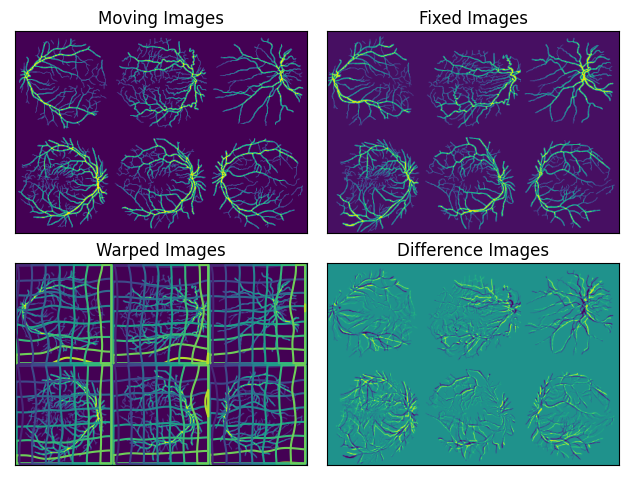

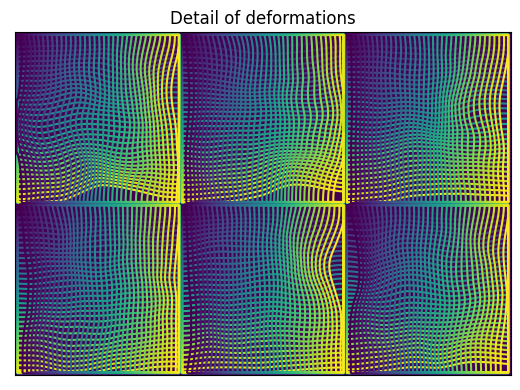

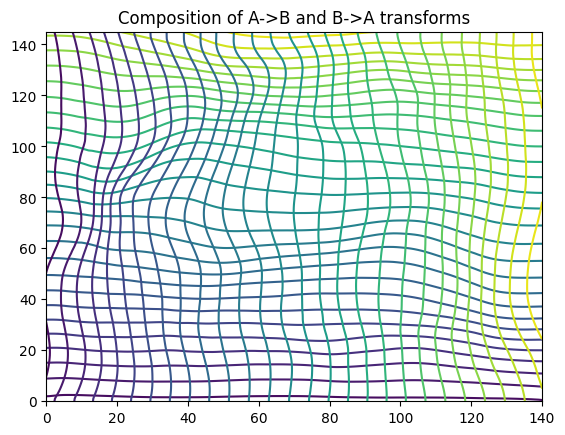

In [3]:
lmbda = 0.001

inner_net = icon.network_wrappers.SquaringVelocityField(networks.tallUNet2(dimension=2))

regular_net = icon.losses.BendingEnergyNet(
        inner_net
    , icon.ssd, lmbda=lmbda)
regular_net.assign_identity_map(sample_batch.shape)
onestep_regular_curves = evaluate(regular_net, "")

In [4]:
regular_net.eval()

BendingEnergyNet(
  (regis_net): SquaringVelocityField(
    (net): UNet2(
      (downConvs): ModuleList(
        (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (upConvs): ModuleList(
        (0): ConvTranspose2d(48, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): ConvTranspose2d(96, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (2): ConvTranspose2d(192, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (3): ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      )
      (b

In [5]:
class FixedTranslationTransform(icon.RegistrationModule):
    def __init__(self, t):
        super().__init__()
        self.register_parameter("t", torch.nn.Parameter(torch.tensor([t])))
        
    def forward(self, image_A, image_B):
        t = torch.cat([self.t, torch.tensor([0]).to(self.t.device)])
        
        return lambda coords: coords + t[None, :, None, None]
        


In [6]:
image_A = next(iter(ds1))[0].to(device)[:]
image_B = next(iter(ds2))[0].to(device)[:]

ag = iter(ds1)
bg = iter(ds2)


In [24]:
trans_net = FixedTranslationTransform(0.0)
trans_net = icon.losses.BendingEnergyNet(
        trans_net
    , icon.LNCC(sigma=5), lmbda=lmbda)
trans_net.assign_identity_map(sample_batch.shape)
trans_net.to(device)

BendingEnergyNet(
  (regis_net): FixedTranslationTransform()
)

In [25]:
trans_net(image_A, image_B)

BendingLoss(all_loss=tensor(1.8776, device='cuda:0', grad_fn=<AddBackward0>), bending_energy_loss=tensor(7.8795e-08, device='cuda:0', grad_fn=<DivBackward0>), similarity_loss=tensor(1.8776, device='cuda:0', grad_fn=<MulBackward0>), transform_magnitude=tensor(0., device='cuda:0', grad_fn=<MeanBackward0>), flips=tensor(0., device='cuda:0'))

In [26]:
import numpy as np

shifts = np.linspace(-.5, .5, 100)
losses_alone = []
gradients_alone = []
for shift in shifts:
    with torch.no_grad():
        trans_net.regis_net.t [:] = shift
    trans_net.zero_grad()
    ag = iter(ds1)
    bg = iter(ds2)
    for _ in range(8):
        image_A = next(ag)[0].to(device)[:]
        image_B = next(bg)[0].to(device)[:]
        loss = trans_net(image_A, image_B)
        loss.similarity_loss.backward()
    gradients_alone.append(trans_net.regis_net.t.grad.item())
    losses_alone.append(loss.similarity_loss.item())
    
    

In [27]:
trans_net.regis_net.t.grad

tensor([0.2056], device='cuda:0')

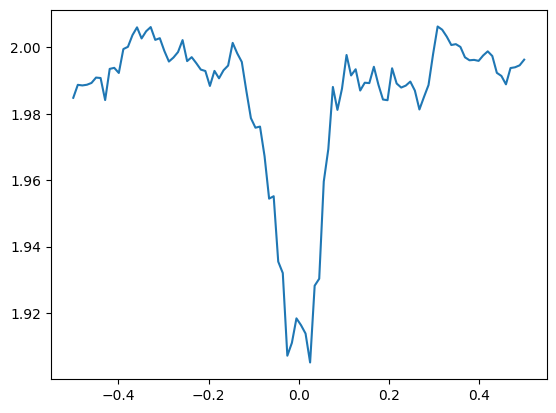

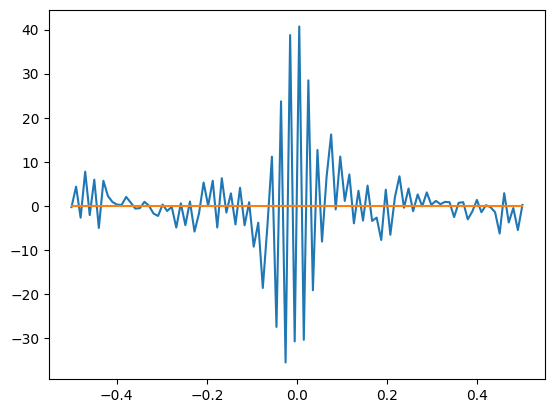

In [28]:
plt.plot(shifts, losses_alone)
plt.show()
plt.plot(shifts, gradients_alone)
plt.plot(shifts, shifts * 0)


In [29]:
trans_net = FixedTranslationTransform(0.0)
compound_trans_net = icon.losses.BendingEnergyNet(
        icon.TwoStepRegistration(trans_net, regular_net.regis_net)
    , icon.LNCC(sigma=5), lmbda=lmbda)
compound_trans_net.assign_identity_map(sample_batch.shape)
compound_trans_net.to(device)

BendingEnergyNet(
  (regis_net): TwoStepRegistration(
    (netPhi): FixedTranslationTransform()
    (netPsi): SquaringVelocityField(
      (net): UNet2(
        (downConvs): ModuleList(
          (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        )
        (upConvs): ModuleList(
          (0): ConvTranspose2d(48, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): ConvTranspose2d(96, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (2): ConvTranspose2d(192, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (3): ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   

In [32]:
import numpy as np

shifts = np.linspace(-.5, .5, 100)
losses_compound = []
gradients_compound = []
for shift in shifts:
    with torch.no_grad():
        compound_trans_net.regis_net.netPhi.t [:] = shift
    compound_trans_net.zero_grad()
    
    ag = iter(ds1)
    bg = iter(ds2)
    for _ in range(8):
        image_A = next(ag)[0].to(device)[:]
        image_B = next(bg)[0].to(device)[:]

        loss = compound_trans_net(image_A, image_B)
        loss.similarity_loss.backward()

    losses_compound.append(loss.similarity_loss.item())
    gradients_compound.append(compound_trans_net.regis_net.netPhi.t.grad.item())
    
    

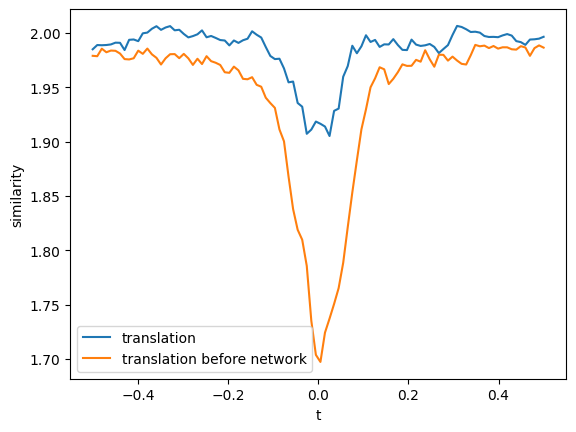

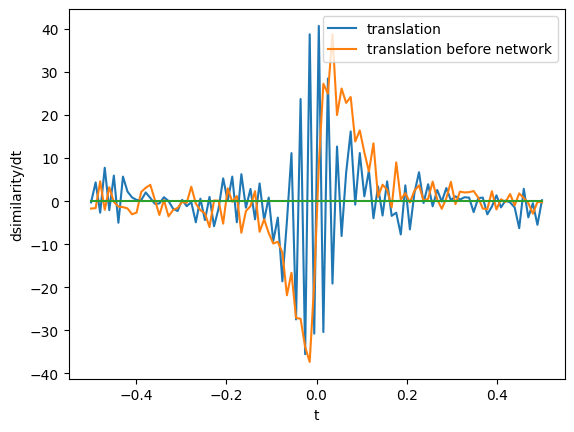

In [33]:
plt.plot(shifts, losses_alone, label="translation")
plt.plot(shifts, losses_compound, label="translation before network")
plt.xlabel("t")
plt.ylabel("similarity")
plt.legend()

plt.show()
plt.plot(shifts, gradients_alone, label="translation")
plt.plot(shifts, gradients_compound, label="translation before network")
plt.xlabel("t")
plt.ylabel("dsimilarity/dt")

plt.plot(shifts, shifts * 0)
plt.legend()
